In [244]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import random
from numba import jit
import time
import dask 
from dask import delayed
from collections import deque
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import pandas as pd
import scipy

In [245]:
import plotly.express as px

Effective stimulus ( $v$ ) follows the Michaelis-Menten Equation:

$$ v = \frac{ v_{max} * S }{ K_d + S} $$

Where:
$v_{max}$ is the maximum possible effective stimulus defined as a funciton of the number of 
receptors ( $nR$ ) a cell has and the catalytic rate constant (degradation rate per receptor) ($K_{cat}$)

default: 
- $ nR = 100$ 
- $k_{cat} = 0.4$ 

$K_d = \frac{k_{off} } {k_{on} }$, defined as a global variables in simulation portion of the code

$S$ is the chemoattractant concentration



In [246]:
def getEffectiveStimulus(v_max, S, K_d):
    '''
    Calculates the effective stimulus (or degree to which the cell is affected by a chemoattractant) 
    according to the relative concentration of the chemoattractant of the cell as well as 
    it's saturation coefficient and the Michaelis-Menten constant.

    Parameters:
        cell (Cell): The cell object to calculate the effective stimulus for where 
            cell.v_max is the maximum reaction of the cell which is determined by the number of 
            receptors the cell is instantiateed with as well as single receptor sensitivity, also
            defined on cell instantiation,
        S (float): The concentration of the chemoattractant at the cell's position.
        K_d (float): The Michaelis-Menten constant defined by k_off / k_on which are 
            defined as global variables 
    
    Returns:
        v (float): The effective stimulus
    '''
    
    v = (v_max * S) / (K_d + S)
    return v

In [247]:
def circle_points(center, radius):
    """
    Calculate all points within a circle in a 2D grid using a rasterization approach,
    returning the points as an array of arrays.

    Parameters:
        center (tuple): The (x, y) coordinates of the circle's center.
        radius (int): Radius of the circle.
    
    Returns:
        list: A list of [x, y] points inside the circle.
    """
    cx, cy = center
  #  radius_squared = radius ** 2
    points = []

    # Use the midpoint circle algorithm to find points
    x, y = radius, 0
    decision = 1 - radius

    while x >= y:
        # Add the points for each octant of the circle as lists
        points.extend([
            [cx + x, cy + y], [cx - x, cy + y], [cx + x, cy - y], [cx - x, cy - y],
            [cx + y, cy + x], [cx - y, cy + x], [cx + y, cy - x], [cx - y, cy - x]
        ])

        y += 1
        if decision <= 0:
            decision += 2 * y + 1
        else:
            x -= 1
            decision += 2 * (y - x) + 1

    # Filter points to ensure they are within the bounds of the grid (optional)
    points = [list(item) for item in set(tuple(point) for point in points)]  # Remove duplicates
    return np.array(points)

In [248]:
@jit(nopython=True)
def _compute_gradient(pos_x, pos_y, u, dx, dy, step = 1):
    '''
    Compute the gradient of a field u at a given position (pos_x, pos_y) using central differences.
    Intended to be used within a wrapped function defined as part of the cell class.
    This version is defined outside the class to allow for the use of numba's JIT compiler.

    Parameters:
        pos_x (int): The x-coordinate of the position.
        pos_y (int): The y-coordinate of the position.
        u (numpy.ndarray): The field to compute the gradient of.
        dx (float): The grid spacing in the x-direction.
        dy (float): The grid spacing in the y-direction.
        step (int): The step size for the gradient computation.

    Returns:
        numpy array: A tuple containing the x and y components of the gradient.
    '''
    x, y = pos_x, pos_y 

    # Compute central difference gradient
    if 1 <= x < u.shape[0] - 1 and 1 <= y < u.shape[1] - 1: # boundary rejection

        grad_x = (u[x+step, y] - u[x-step, y]) / (2 * dx) # x grad
        grad_y = (u[x, y+step] - u[x, y-step]) / (2 * dy) # y grad
    
    else:
        grad_x, grad_y = 0, 0 
    
    return grad_x, grad_y

In [249]:
def degrade_pos_gen(center_x, center_y, side_length, grid_shape): 
    '''
    Function intended to run a single time. Calculates the area of degradation for a given cell perimeter.
    The area is updated as the cell moves using the same movement vector as the cell.
    
    Parameters:
        center_x (int): The x-coordinate of the center of the cell.
        center_y (int): The y-coordinate of the center of the cell.
        side_length (int): The side length of the square area to be degraded.
        grid_shape (tuple): The shape of the grid as (height, width).
    
    Returns:
        numpy.ndarray: An array of shape (N, 2) where N is the number of positions in the degraded area.
        Each row contains the (x, y) coordinates of a position within the degraded area.
    '''

    grid_h, grid_w = grid_shape

    str_x = max(0, center_x - side_length // 2)
    end_x = min(grid_w, center_x + side_length // 2 + 1)

    str_y = max(0, center_y - side_length // 2) 
    end_y = min(grid_h, center_y + side_length // 2 + 1)   

    x = np.arange(str_x, end_x)
    y = np.arange(str_y, end_y)

    x_mesh, y_mesh = np.meshgrid(x, y)

        # Stack x and y coordinates into a single array
    positions = np.vstack((x_mesh.ravel(), y_mesh.ravel())).T
    
    return positions

In [251]:
class Cell_2():
    """
    This class represents a cell in a grid environment. The cell can move, secrete attractants, and respond to gradients.
    It keeps track of its position and stimulation history.

    Attributes:
        v_max (float): Maximum velocity of the cell.
        default (bool): Indicates if the cell has a default shape.
        degRadius (int): Radius of the degradation area.
        degArea (np.ndarray): Degradation area positions.
        secrete (bool): Indicates if the cell secretes attractants.
        points (np.ndarray): Points representing the cell's shape.
        shape (str): Shape of the cell.
        pos_x (int): X-coordinate of the cell's centroid position.
        pos_y (int): Y-coordinate of the cell's centroid position.
        pos_history (deque): History of the cell's positions.
        RS_history (deque): History of the cell's stimulation and gradient responses.
    """

    def __init__(self, grid, pos_x, pos_y, shape=["circle", 1], degradation_area=1, nR=100, k_cat=0.4, secretion=False):
        """
        Initializes the Cell_2 object with the given parameters.

        Args:
            grid (np.ndarray): The grid environment.
            pos_x (int): Initial x-coordinate of the cell.
            pos_y (int): Initial y-coordinate of the cell.
            shape (list): Shape of the cell, default is ["circle", 1].
            degradation_area (int): Radius of the degradation area.
            nR (int): Number of receptors.
            k_cat (float): Catalytic rate constant.
            secretion (bool): Indicates if the cell secretes attractants.
        """
        self.v_max = nR * k_cat
        self.default = True
        self.degRadius = degradation_area
        self.degArea = degrade_pos_gen(pos_x, pos_y, degradation_area, grid.shape)
        self.secrete = secretion

        if shape[0] == "circle" and shape[1] > 1:
            self.default = False
            self.points = circle_points((pos_x, pos_y), shape[1])
        else:
            self.points = np.array([[pos_x, pos_y]])
            
        self.shape = shape[0]
        self.pos_x = int(pos_x)
        self.pos_y = int(pos_y)
        self.pos_history = deque()
        self.pos_history.append([0, self.pos_x, self.pos_y])

        self.RS_history = deque()

    def update_pos(self, grid_size, step=1):
        """
        Updates the position of the cell randomly within the grid boundaries.

        Args:
            grid_size (int): Size of the grid.
            step (int): Step size for the random movement.
        """
        if self.default:
            self.pos_x = np.clip(self.pos_x + np.random.randint(-step, step), 0, grid_size - 1)
            self.pos_y = np.clip(self.pos_y + np.random.randint(-step, step), 0, grid_size - 1)
        else:
            self.points = np.clip(self.points + [np.random.randint(-step, step), np.random.randint(-step, step)], 0, grid_size - 1)

    def attractant_secretion_rule(self, rule="random"):
        """
        Determines if the cell secretes an attractant based on a random or user defined rule.

        Args:
            rule (str): Rule for secretion, default is "random".

        Returns:
            bool: True if the cell secretes an attractant, False otherwise.
        """
        if random.uniform(0, 1) < 0.001:
            return True
        else:
            return False

    def compute_gradient(self, u, dx, dy, step=1):
        """
        Computes the gradient at the cell's position.

        Args:
            u (np.ndarray): Concentration field.
            dx (float): Grid spacing in the x-direction.
            dy (float): Grid spacing in the y-direction.
            step (int): Step size for the gradient computation.

        Returns:
            tuple: Gradient in the x and y directions.
        """
        grad_x, grad_y = _compute_gradient(self.pos_x, self.pos_y, u, dx, dy, step)
        return grad_x, grad_y

    def update_pos_grad(self, u, dx, dy, sensitivity, time_curr, dt, grid_shape, step=1):
        """
        Updates the position of the cell based on the gradient and random movement.

        Args:
            u (np.ndarray): Concentration field.
            dx (float): Grid spacing in the x-direction.
            dy (float): Grid spacing in the y-direction.
            sensitivity (float): Sensitivity of the cell to the gradient.
            time_curr (float): Current time.
            dt (float): Time step.
            grid_shape (tuple): Shape of the grid.
            step (int): Step size for the random movement.
        """
        global K_d
        grad_x, grad_y = self.compute_gradient(u, dx, dy)

        # Random movement with gradient influence
        rand_x = random.randint(-step, step)
        rand_y = random.randint(-step, step)

        v_max = self.v_max

        S = u[self.pos_x, self.pos_y]
        v = getEffectiveStimulus(v_max, S, K_d)

        sensitivity = v / v_max  # Sensitivity is defined as the ratio of the effective stimulus to the maximum stimulus

        self.RS_history.append([time_curr + dt, v, (grad_x + grad_y) / 2])

        # Generate movement vector
        move_x = int(rand_x + grad_x * sensitivity)
        move_y = int(rand_y + grad_y * sensitivity)

        # Apply the movement to all points
        mov_vector = np.array([move_y, move_x])
        self.points += mov_vector
        self.pos_x += move_x
        self.pos_y += move_y

        self.degArea += mov_vector

        # Boundary values
        x_min, x_max = 0, grid_shape[0] - 1
        y_min, y_max = 0, grid_shape[1] - 1

        # Find points outside the grid
        outside_points = self.points[
            (self.points[:, 0] < x_min) | (self.points[:, 0] > x_max) |
            (self.points[:, 1] < y_min) | (self.points[:, 1] > y_max)
        ]

        if outside_points.size > 0:
            # Compute correction vector as the negative sum of out-of-bounds offsets
            correction_vector = np.array([
                -np.sum(outside_points[:, 0] - np.clip(outside_points[:, 0], x_min, x_max)),
                -np.sum(outside_points[:, 1] - np.clip(outside_points[:, 1], y_min, y_max))
            ])

            # Apply correction to all points and the center
            self.points += correction_vector
            self.pos_x += correction_vector[1]
            self.pos_y += correction_vector[0]

            self.degArea += correction_vector

        # Append the position to history
        self.pos_history.append([time_curr + dt, self.pos_x, self.pos_y])

    def get_position_history(self, type="list"):
        """
        Returns the position history of the cell.

        Args:
            type (str): Format of the returned history, can be "list", "df", or "dict".

        Returns:
            list/pd.DataFrame/dict: Position history in the specified format.
        """
        if type == "list":
            return list(self.pos_history)
        elif type == "df":
            df = pd.DataFrame(list(self.pos_history), columns=["time_step", "pos_x", "pos_y"])
            return df
        elif type == "dict":
            return {"time_step": [x[0] for x in self.pos_history], "pos_x": [x[1] for x in self.pos_history], "pos_y": [x[2] for x in self.pos_history]}

    def get_stimulation_stats(self, type="list"):
        """
        Returns the stimulation and gradient response history of the cell.

        Args:
            type (str): Format of the returned history, can be "list", "df", or "dict".

        Returns:
            list/pd.DataFrame/dict: Stimulation and gradient response history in the specified format.
        """
        if type == "list":
            return list(self.RS_history)
        elif type == "df":
            df = pd.DataFrame(list(self.RS_history), columns=["time_step", "effective_stimulus", "gradient_magnitude"])
            return df
        elif type == "dict":
            return {"time_step": [x[0] for x in self.RS_history], "effective_stimulus": [x[1] for x in self.RS_history], "gradient_magnitude": [x[2] for x in self.RS_history]}


In [252]:
#PARAMS
k_on = 2e2  # M^-1 s^-1#
k_off = 10e4 # s^-1

K_d = k_off / k_on # M

alpha = 50
length = 400
sim_time = 8
nodes = 250
num_cells= 4


dx = length / nodes
dy= length / nodes


dt = min(dx**2 / (4*alpha), dy**2 / (4*alpha))

t_nodes = int(sim_time/dt)

u = np.zeros((nodes, nodes))
# if using non square environment we use the smaller coefficient

array_len = len(u)

max_temp = 100

u[:,-1:-10] = max_temp
#u[:,int(nodes*0.75):]= max_temp
u[0:75,:] = max_temp
#u[ int(len(u)/2): int(len(u)/2)] = 100

center_x, center_y = nodes // 2, nodes // 2
radius = 15  # Radius of high tempera

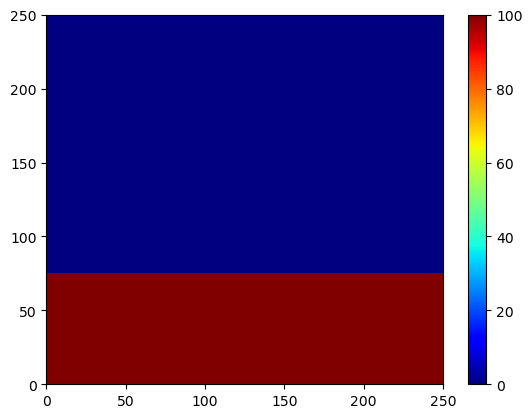

In [253]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(u, cmap = plt.cm.jet, vmin=0, vmax=100)
plt.colorbar(pcm, ax=axis)


In [254]:
cells = [Cell_2( u, int(nodes/ 2), int( nodes / 2), secretion=True, degradation_area=2) for _ in range(num_cells)]
counter = 0 
cellMarker = []

### Compiled function calculating a time-step update of the diffusion of a chemoattractant according to the heat equation where "heat" is the concentration of the chemoattractant:


$$\frac {\partial C}{\partial t} = \alpha \frac {\partial^2 C}{\partial x^2} $$

This is computed using the explicit Finite-Difference Numerical Method, in the future this should be updated to the Crank-Nicolson method for small time steps to ensure stability or the implicit method for larger time steps

Finite Difference Method: 
$$ u^\prime[x] = \frac{u[x-dx] - 2* u[dx] + u [x + dx]} {dx^2} $$
$$ u^\prime[y] = \frac{u[y-dy] - 2* u[y] + u [x + dy]} {dy^2} $$

In [255]:

@jit(nopython=True)
def calc_grad_np(u):
    """
    Calculate the gradient using NumPy arrays with JIT compilation.

    This function computes the gradient of a 2D array `u` using finite difference 
    methods and updates the array `w` accordingly. The function is optimized 
    using Numba's JIT compilation for improved performance.

    Parameters:
    u (numpy.ndarray): 2D array representing the input data.

    Returns:
    numpy.ndarray: 2D array `w` with the computed gradient values.
    """
    w = u.copy()
    w[1:-1, 1:-1] = (
        u[1:-1, 1:-1]
        + alpha * dt * (
            (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2
            + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
        )
    )
    return w

In [256]:
def update_cell(c, u, dx, dy, counter, dt, grid_size):
    
    c.update_pos_grad(u, dx, dy, 0.5, counter, dt, grid_size)

    if c.degRadius > 1:

        x_min, x_max = 0, u.shape[1] - 1
        y_min, y_max = 0, u.shape[0] - 1

        clipped_degArea = np.copy(c.degArea)
        clipped_degArea[:, 0] = np.clip(clipped_degArea[:, 0], y_min, y_max)  # Y-axis
        clipped_degArea[:, 1] = np.clip(clipped_degArea[:, 1], x_min, x_max)  # X-axis

        u[clipped_degArea[:,1], clipped_degArea[:,0]] = u[clipped_degArea[:,1], clipped_degArea[:,0]] / 10


        #u[c.degArea[:,1], c.degArea[:,0]] = u[c.degArea[:,1], c.degArea[:,0]] / 10
    else:
        u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] / 10
        if c.secrete:
            if c.attractant_secretion_rule():
                u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] + 40
        
    return c

In [257]:
gradient_history = deque()

In [258]:
start = time.time()

while counter < sim_time : # O(t)

    w = u.copy()
    if cellMarker:
        for mark in cellMarker: # O(n)
            mark.remove()

    u = calc_grad_np(u) 

    tasks = [ delayed (update_cell)(c, u, dx, dy, counter, dt, u.shape) for c in cells ]
        
    
    results = dask.compute(*tasks)

   # print("t: {:.3f} [s], Concentration {:.2f} %".format(counter, np.average(u)))

  #  pcm.set_array(u)
   # axis.set_title("Distribution at t: {:.3f} [s].".format(counter))


    try:
        cellMarker = [axis.plot(cell.points[:,0] , cell.points[:,1], 'wo', markersize=1)[0] for cell in cells]  
    except:
        print("Error in plotting")
        for cell in cells:
            print(cell.points)
        exit(1)
 
  #  plt.pause(0.01)
    counter += dt
    
end = time.time()
FINAL = end - start

print(f'Total Execution Time: {FINAL}')

Total Execution Time: 1.5809941291809082


In [259]:
#Simulation placed in a wrapper function to aid in testing execution times
def go(sim_time, num_cells=4, length= 400, nodes = 250):

    #PARAMS
    k_on = 2e2  # M^-1 s^-1#
    k_off = 10e4 # s^-1

    K_d = k_off / k_on # M

    alpha = 50
   # length = 400

    #nodes = 250


    dx = length / nodes
    dy= length / nodes


    dt = min(dx**2 / (4*alpha), dy**2 / (4/alpha))

    t_nodes = int(sim_time/dt)

    u = np.zeros((nodes, nodes))
    # if using non square environment we use the smaller coefficient

    array_len = len(u)

    max_temp = 100

    u[:,-1:-10] = max_temp
    #u[:,int(nodes*0.75):]= max_temp
    u[0:75,:] = max_temp
    #u[ int(len(u)/2): int(len(u)/2)] = 100

    center_x, center_y = nodes // 2, nodes // 2
    radius = 15  # Radius of high tempera
    
    cells = [Cell_2( u, int(nodes/ 2), int( nodes / 2), secretion=True, degradation_area=2) for _ in range(num_cells)]
    
    counter = 0 
    cellMarker = []

    counter = 0
    start = time.time()

    while counter < sim_time : # O(t)

        w = u.copy()
      #  if cellMarker:
      #      for mark in cellMarker: # O(n)
      #          mark.remove()

        u = calc_grad_np(u) 

        tasks = [ delayed (update_cell)(c, u, dx, dy, counter, dt, u.shape) for c in cells ]
            
        
        results = dask.compute(*tasks)

    # print("t: {:.3f} [s], Concentration {:.2f} %".format(counter, np.average(u)))

    #  pcm.set_array(u)
    # axis.set_title("Distribution at t: {:.3f} [s].".format(counter))
    
    #  plt.pause(0.01)
        counter += dt
        
    end = time.time()
    fin = end - start
    return fin
    

In [260]:
test_cell = cells[0]

In [261]:
df = test_cell.get_stimulation_stats("df")

In [262]:
stats = [dfs.get_stimulation_stats("merged_merged_merged_df") for dfs in cells]

In [263]:
cell_1 = test_cell
cell_2 = cells[1]

In [264]:
cell_1_pos = cell_1.get_position_history("df")
cell_2_pos = cell_2.get_position_history("df")

In [265]:
cell_2_pos

,time_step,pos_x,pos_y
0,0.0000,125,125
1,0.0128,125,126
2,0.0256,126,127
3,0.0384,127,128
4,0.0512,128,128
...,...,...,...
621,7.9488,38,28
622,7.9616,38,28
623,7.9744,38,28
624,7.9872,39,28


In [325]:
def merge_cell_pos_df(cells, on="time_step"):
    """
    Merges the position history dataframes of multiple cell objects on a specified column.

    Parameters:
        cells (list): List of cell objects.
        on (str): Column name to merge the dataframes on. Default is "time_step".

    Returns:
        pd.DataFrame: Merged dataframe containing the position history of all cells.
    """
    dfs = [cell.get_position_history("df") for cell in cells]
    merged_df = dfs[0]
    
    for i, df in enumerate(dfs[1:], start=2):
        merged_df = pd.merge(merged_df, df, on=on, suffixes=(f"_{i-1}", f"_{i}"))
    
    return merged_df

In [327]:
merged_df = merge_cell_pos_df([cell_1, cell_2])

In [328]:
#merged_df = pd.merge(cell_1_pos, cell_2_pos, on="time_step", suffixes=("_1", "_2"))

# Compute distance
merged_df["distance"] = np.sqrt(
    (merged_df["pos_x_1"] - merged_df["pos_x_2"])**2 +
    (merged_df["pos_y_1"] - merged_df["pos_y_2"])**2
)

In [ ]:
def compute_distances_cells(merged_df):
    merged_df["distance"] = np.sqrt(
        (merged_df["pos_x_1"] - merged_df["pos_x_2"])**2 +
        (merged_df["pos_y_1"] - merged_df["pos_y_2"])**2
    )
    return merged_df

In [329]:
merged_df

,time_step,pos_x_1,pos_y_1,pos_x_2,pos_y_2,distance
0,0.0000,125,125,125,125,0.000000
1,0.0128,124,126,125,126,1.000000
2,0.0256,123,125,126,127,3.605551
3,0.0384,124,126,127,128,3.605551
4,0.0512,123,126,128,128,5.385165
...,...,...,...,...,...,...
621,7.9488,47,15,38,28,15.811388
622,7.9616,47,15,38,28,15.811388
623,7.9744,47,15,38,28,15.811388
624,7.9872,46,15,39,28,14.764823


In [268]:
dx1, dy1 = merged_df['pos_x_1'].diff(), merged_df['pos_y_1'].diff()
dx2, dy2 = merged_df['pos_x_2'].diff(), merged_df['pos_y_2'].diff()

In [269]:
dx1 = merged_df['pos_x_1'].diff().fillna(0)
dy1 = merged_df['pos_y_1'].diff().fillna(0)
dx2 = merged_df['pos_x_2'].diff().fillna(0)
dy2 = merged_df['pos_y_2'].diff().fillna(0)

In [270]:
theta1 = np.arctan2(dy1, dx1)
theta2 = np.arctan2(dy2, dx2)


In [271]:
delta_theta1 = np.abs(np.diff(theta1))
delta_theta2 = np.abs(np.diff(theta2))

In [272]:
threshold = 10  # Define proximity threshold
proximity = merged_df['distance'][:-1] < threshold

In [273]:
# Extract delta_theta when cells are close vs far
delta_close = delta_theta1[proximity]
delta_far = delta_theta1[~proximity]

In [274]:
from scipy.stats import ttest_ind

In [275]:
delta_close

array([2.35619449, 4.71238898, 3.14159265, 2.35619449, 2.35619449,
       1.57079633, 4.71238898, 2.35619449, 1.57079633, 0.        ,
       1.57079633, 0.        , 0.        , 1.57079633, 3.14159265,
       3.14159265, 1.57079633, 3.14159265, 2.35619449, 1.57079633,
       0.78539816, 1.57079633, 3.14159265, 4.71238898, 0.        ,
       3.92699082, 0.78539816, 0.78539816, 0.        , 3.14159265,
       3.92699082, 0.        , 1.57079633, 0.78539816, 0.        ,
       0.78539816, 3.14159265, 2.35619449, 2.35619449, 0.        ,
       3.14159265, 3.14159265, 0.        , 0.        , 3.14159265,
       2.35619449, 1.57079633, 1.57079633, 0.78539816, 1.57079633,
       2.35619449, 0.        , 0.        , 1.57079633, 1.57079633,
       0.78539816, 5.49778714, 2.35619449, 3.14159265, 3.14159265,
       0.        , 0.78539816, 0.78539816, 0.        , 1.57079633,
       0.78539816, 2.35619449, 0.78539816, 0.78539816, 5.49778714,
       2.35619449, 0.        , 3.14159265, 2.35619449, 0.78539

In [276]:
stat, p_value = ttest_ind(delta_close, delta_far, equal_var=False)

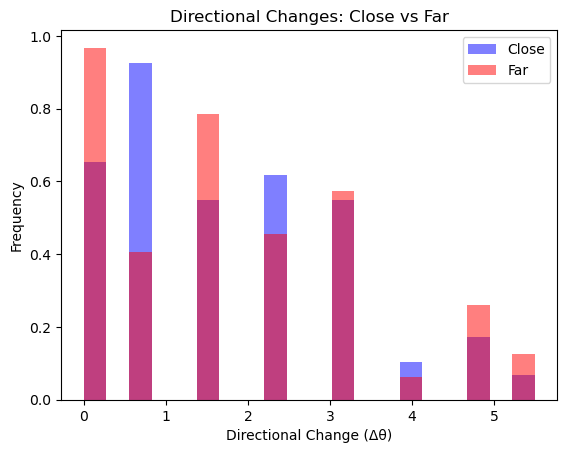

Mean Δθ (Close): 1.75
Mean Δθ (Far): 1.81
T-test p-value: 0.67490


In [277]:
plt.hist(delta_close, bins=20, alpha=0.5, label='Close', color='blue', density=True)
plt.hist(delta_far, bins=20, alpha=0.5, label='Far', color='red', density=True)
plt.xlabel("Directional Change (Δθ)")
plt.ylabel("Frequency")
plt.title("Directional Changes: Close vs Far")
plt.legend()
plt.show()

print(f"Mean Δθ (Close): {np.mean(delta_close):.2f}")
print(f"Mean Δθ (Far): {np.mean(delta_far):.2f}")
print(f"T-test p-value: {p_value:.5f}")

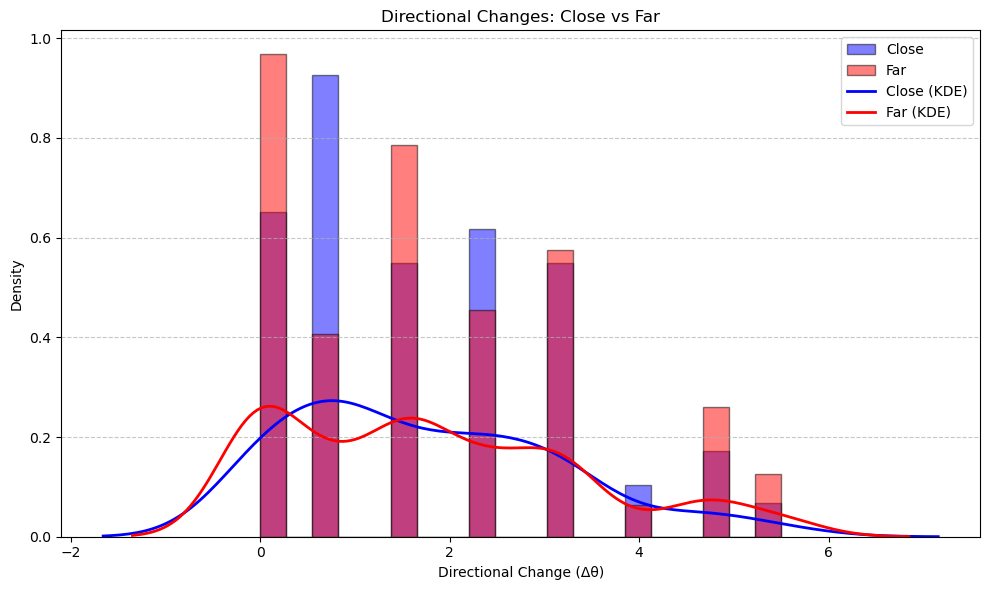

In [278]:
import seaborn as sns

# Plot histograms with better visuals
plt.figure(figsize=(10, 6))

# Histogram with transparency
plt.hist(delta_close, bins=20, alpha=0.5, label='Close', color='blue', density=True, edgecolor='black')
plt.hist(delta_far, bins=20, alpha=0.5, label='Far', color='red', density=True, edgecolor='black')

# Add KDE for smooth comparison
sns.kdeplot(delta_close, color='blue', label='Close (KDE)', linewidth=2)
sns.kdeplot(delta_far, color='red', label='Far (KDE)', linewidth=2)

# Add labels and legend
plt.xlabel("Directional Change (Δθ)")
plt.ylabel("Density")
plt.title("Directional Changes: Close vs Far")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [279]:
dx1 = merged_df['pos_x_1'].diff().dropna().values  # Movement in x for cell 1
dy1 = merged_df['pos_y_1'].diff().dropna().values  # Movement in y for cell 1
dx2 = merged_df['pos_x_2'].diff().dropna().values  # Movement in x for cell 2
dy2 = merged_df['pos_y_2'].diff().dropna().values

In [280]:
from scipy.signal import correlate

In [281]:
cross_corr_x = correlate(dx1, dx2, mode="full")
cross_corr_y = correlate(dy1, dy2, mode="full")

cross_corr_x /= np.linalg.norm(dx1) * np.linalg.norm(dx2)
cross_corr_y /= np.linalg.norm(dy1) * np.linalg.norm(dy2)

In [282]:
gradient_field_history = list(gradient_history)

In [283]:
gradient_field_history

[]

In [284]:
from numpy.polynomial.polynomial import Polynomial
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_statistics(df, columns, polynomial_fit=True, degree=3):
    """
    Plots the statistics of the given dataframe with optional polynomial trendlines.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data to plot.
    columns (list): A list of column names to plot. The first element is the x-axis column,
                    the second element is the primary y-axis column, and the third element
                    is the secondary y-axis column.
    polynomial_fit (bool): Whether to fit and plot polynomial trendlines. Default is True.
    degree (int): The degree of the polynomial to fit. Default is 3.

    Returns:
    None
    """
    
    x_col = columns[0]
    y_col = columns[1]
    y_col2 = columns[2]

    if polynomial_fit:
        # Fit polynomial regression to the data
        poly_effective = Polynomial.fit(df[x_col], df[y_col], degree)
        poly_gradient = Polynomial.fit(df[x_col], df[y_col2], degree)

        # Generate trendline values
        trend_effective = poly_effective(df[x_col])
        trend_gradient = poly_gradient(df[x_col])

    # Create a subplot with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add the primary y-axis data trace
    fig.add_trace(
        go.Scatter(
            x=df[x_col],
            y=df[y_col],
            name="Effective Stimulus",
            line=dict(color="blue"),
        ),
        secondary_y=False,
    )

    if polynomial_fit:
        # Add the polynomial trendline for the primary y-axis
        fig.add_trace(
            go.Scatter(
                x=df[x_col],
                y=trend_effective,
                name=y_col + " (Poly Trendline)",
                line=dict(color="cyan", width=3),
            ),
            secondary_y=False,
        )

    # Add the secondary y-axis data trace
    fig.add_trace(
        go.Scatter(
            x=df[x_col],
            y=df[y_col2],
            name=y_col2,
            line=dict(color="red"),
        ),
        secondary_y=True,
    )

    if polynomial_fit:
        # Add the polynomial trendline for the secondary y-axis
        fig.add_trace(
            go.Scatter(
                x=df[x_col],
                y=trend_gradient,
                name=y_col2 + " (Poly Trendline)",
                line=dict(color="orange", width=3),
            ),
            secondary_y=True,
        )

    # Update layout and axis titles
    fig.update_layout(
        title_text="Stimulation Statistics with Polynomial Trendlines",
        xaxis_title=x_col,
    )

    fig.update_yaxes(title_text=y_col, secondary_y=False)
    fig.update_yaxes(title_text=y_col2, secondary_y=True)

    # Show the plot
    fig.show()


In [285]:
plot_statistics(df, columns = ["time_step", "effective_stimulus", "gradient_magnitude"], polynomial_fit=True, degree=3)

In [286]:
test_cell1 = cells[0].get_position_history(type="df")

In [287]:
test_cell1

,time_step,pos_x,pos_y
0,0.0000,125,125
1,0.0128,124,126
2,0.0256,123,125
3,0.0384,124,126
4,0.0512,123,126
...,...,...,...
621,7.9488,47,15
622,7.9616,47,15
623,7.9744,47,15
624,7.9872,46,15


In [288]:
cell_0_pos_history = np.array(cells[0].get_position_history())
cell_1_pos_history = np.array(cells[1].get_position_history())
cell_2_pos_history = np.array(cells[2].get_position_history())
cell_3_pos_history = np.array(cells[3].get_position_history())


In [289]:
def plot_cell_history(cell_history):
    """
    Plots the trajectory of cell movement over time with a gradient line colored by time steps.

    This legacy function visualizes the movement of a cell by plotting its x and y positions over time.
    The trajectory is represented with a gradient line where the color indicates the time step.
    The start and end points of the trajectory are annotated with green and red markers, respectively.

    Parameters:
    cell_history (numpy.ndarray): A 2D array where each row represents a time step. The first column
                                  contains the time steps, the second column contains the y positions,
                                  and the third column contains the x positions.

    Returns:
    None

    Note:
    This function uses matplotlib for plotting and numpy for array manipulation.
    """
    time_steps = cell_history [:,0]
    x_pos = cell_history [:,2]
    y_pos = cell_history [:,1]

    points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.gca().add_collection(lc)
    plt.plot(x_pos, y_pos, color='black', alpha=0.1)
    # Annotate start and end
    plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

    plt.colorbar(lc, label='Time Step')
    plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.legend()
    plt.show()

In [290]:

def plot_history_2(position_history, ax=None, color=None, cmap='viridis', label='Cell Path'):
    """
    Plots a cell's movement on a 2-Dimensional grid with a gradient line colored by time step

    Parameters:
    - position_history (np.ndarray): Array of shape (n, 3) where each row is [time_step, x, y].
    - ax (matplotlib.axes._axes.Axes, optional): Axis to plot on. If None, a new figure and axis are created.
    - cmap (str, optional): Colormap for the trajectory.
    - label (str, optional): Label for the cell trajectory.
    
    Returns:
    - fig (matplotlib.figure.Figure): The figure object.
    - ax (matplotlib.axes._axes.Axes): The axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Extract time steps, x positions, and y positions
    time_steps = position_history[:, 0]
    x_positions = position_history[:, 2]
    y_positions = position_history[:, 1]

    # Create segments for LineCollection
    points = np.array([x_positions, y_positions]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.plot(x_positions, y_positions, color=color, alpha=0.3)  # Base path with markers for reference

    # Annotate start and end
    ax.scatter(x_positions[0], y_positions[0], label='Start', zorder=5)
    ax.scatter(x_positions[-1], y_positions[-1], label='End', zorder=5)

    ax.set_title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()

    return fig, ax, lc

/var/folders/_4/kt858wtj2111y2396_n7rtsm0000gn/T/ipykernel_37290/3141811289.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



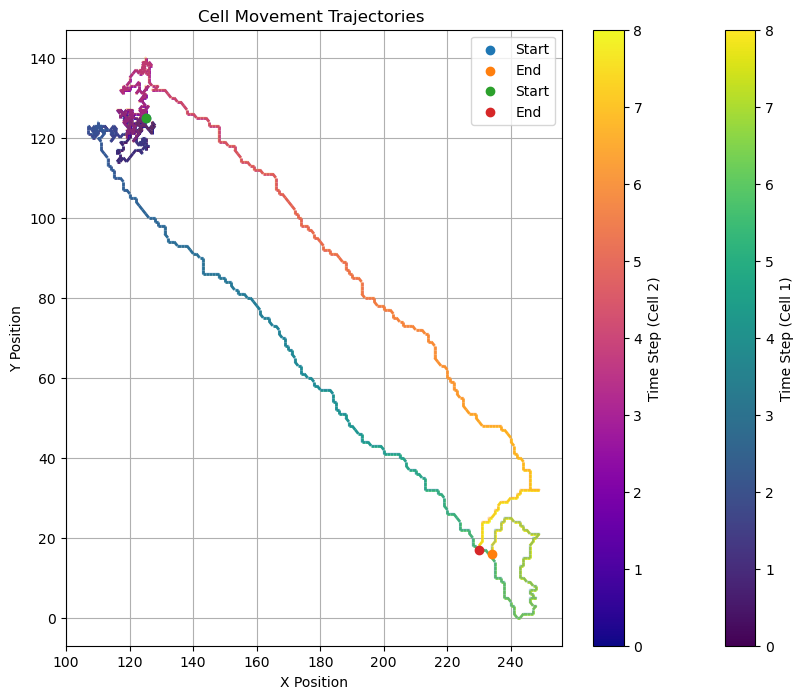

In [291]:
fig, ax = plt.subplots(figsize=(10,8))

trajectories = [ cell_2_pos_history, cell_3_pos_history]

num_trajectories = len(trajectories)
colors = cm.get_cmap('hsv', num_trajectories)


colormaps = ['viridis','plasma', 'winter']

for idx, traj in enumerate(trajectories):
    fig, ax, lc = plot_history_2(traj, ax=ax, cmap=colormaps[idx], label=f'Cell {idx + 1}')
    cbar = plt.colorbar(lc, ax=ax, label=f'Time Step (Cell {idx + 1})')
    cbar.set_label(f'Time Step (Cell {idx + 1})')
    
ax.legend()
plt.title("Cell Movement Trajectories ")
plt.show()

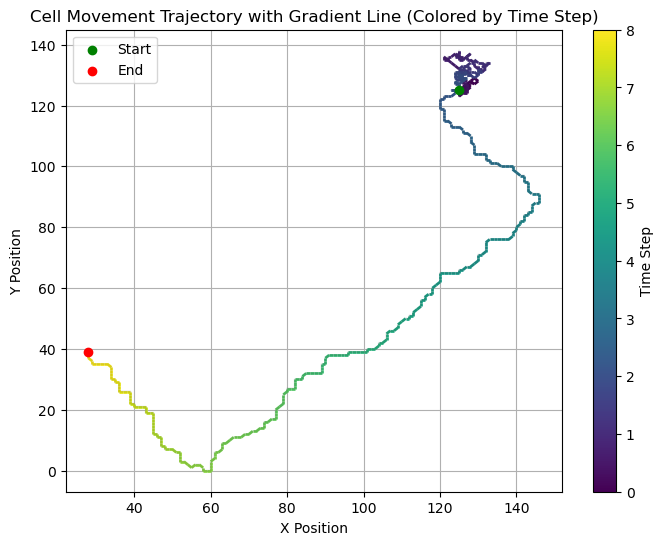

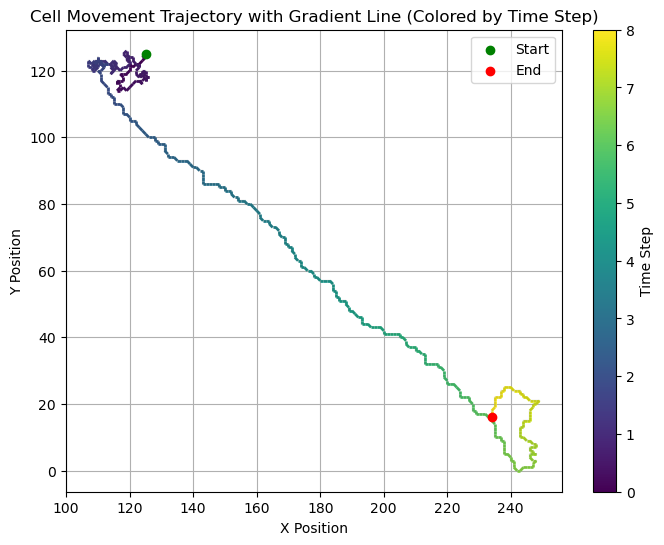

In [292]:
plot_cell_history(cell_1_pos_history)
plot_cell_history(cell_2_pos_history)